<table align="center">        
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1IBWibQWdS8VA_DJSQcqn2gOGe8isP1XQ?usp=sharing">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  
       
</table>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
import os, re, time, json
import pickle
import math

Loading the dataset

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()


170500096/170498071 [==============================] - 13s 0us/step


In [3]:
train_data_clean = train_data_clean.astype('float32') / 255.0
test_data_clean = test_data_clean.astype('float32') / 255.0

Adding noise to our dataset

In [4]:
mean=0.0
sigma=0.3
def add_noise(data):
   noise = np.random.normal(loc=mean, scale=sigma, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [5]:
train_data_noisy = add_noise(train_data_clean)
test_data_noisy = add_noise(test_data_clean)

Sample noisy image

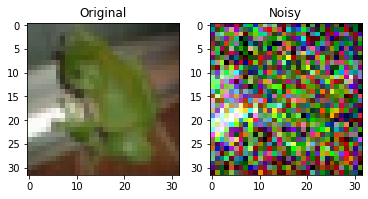

In [6]:
idx = 7
plt.subplot(1,2,1)
plt.imshow(test_data_clean[idx])
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(test_data_noisy[idx])
plt.title('Noisy')


plt.show()


In [ ]:
pwd

'/content/drive/My Drive/history'

Defining our Network architecture(10 convolutional layers).                             
Line 16-42 should be commented to use a 5 Convolutional layered network

In [19]:
inputs = Input(shape=(32,32,3))

# Encoder
x = Conv2D(128, 3, activation='relu', padding='same')(inputs)

skip1 = Conv2D(128, 3, padding='same')(x) # To give skip connection for our decoder
x = ReLU()(skip1)

x = Conv2D(128, 3, activation='relu', padding='same')(x)

skip2 = Conv2D(128, 3, padding='same')(x) # To give skip connection for our decoder
x = ReLU()(skip2)

x = Conv2D(128, 3, activation='relu', padding='same')(x)

skip3 = Conv2D(128, 3, padding='same')(x) # To give skip connection for our decoder
x = ReLU()(skip3)

x = Conv2D(128, 3, activation='relu', padding='same')(x)

skip4 = Conv2D(128, 3, padding='same')(x) # To give skip connection for our decoder
x = ReLU()(skip4)

x = Conv2D(128, 3, activation='relu', padding='same')(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)


# Decoder
x = Conv2DTranspose(128, 3,activation='relu', padding='same')(x)

x = Conv2DTranspose(128, 3, padding='same')(x)
x = add([x,skip4]) # adding skip connection from encoder
x = ReLU()(x)

x = Conv2DTranspose(128, 3, activation='relu', padding='same')(x)

x = Conv2DTranspose(128, 3, padding='same')(x)
x = add([x,skip3]) # adding skip connection from encoder
x = ReLU()(x)

x = Conv2DTranspose(128, 3, activation='relu', padding='same')(x)

x = Conv2DTranspose(128, 3, padding='same')(x)
x = add([x,skip2]) # adding skip connection from encoder
x = ReLU()(x)

x = Conv2DTranspose(128, 3, activation='relu', padding='same')(x)

x = Conv2DTranspose(128, 3, padding='same')(x)
x = add([x,skip1]) # adding skip connection from encoder
x = ReLU()(x)

x = Conv2DTranspose(128, 3, activation='relu', padding='same')(x)

decoded = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mse')
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 128)  3584        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 128)  147584      conv2d_20[0][0]                  
__________________________________________________________________________________________________
re_lu_16 (ReLU)                 (None, 32, 32, 128)  0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [ ]:
epochs = 40
batch_size =256

history= autoencoder.fit(train_data_noisy,
                         train_data_clean,
                         epochs=epochs, 
                         batch_size=batch_size,
                         shuffle=True,
                         validation_data=(test_data_noisy,test_data_clean)
                         )
autoencoder.save("model_10conv.h5")

In [ ]:
dump_name='history_10conv.pickle'
pickle.dump(history.history, open(dump_name,'wb'))

Plotting mse

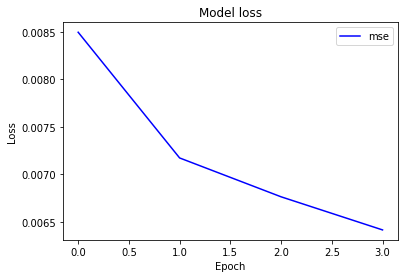

In [11]:
plt.plot(history.history['loss'],'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['mse'])

plt.show()

Plotting PSNR

In [12]:
psnr=20*np.log10(1.0/np.sqrt(history.history['loss']))


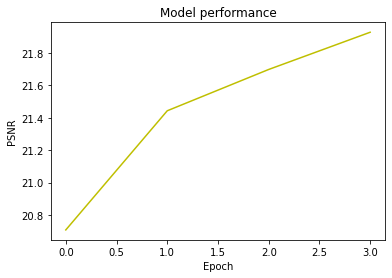

In [15]:
plt.plot(psnr,'y')
plt.title('Model performance')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
# plt.legend(['0.1','0.3','0.5','0.7','1.0'])
plt.show()

In [16]:
h=pickle.load(open('history_10conv.pickle','rb'))


Denoising some images from the test data

In [17]:
test_data_denoised = autoencoder.predict(test_data_noisy)

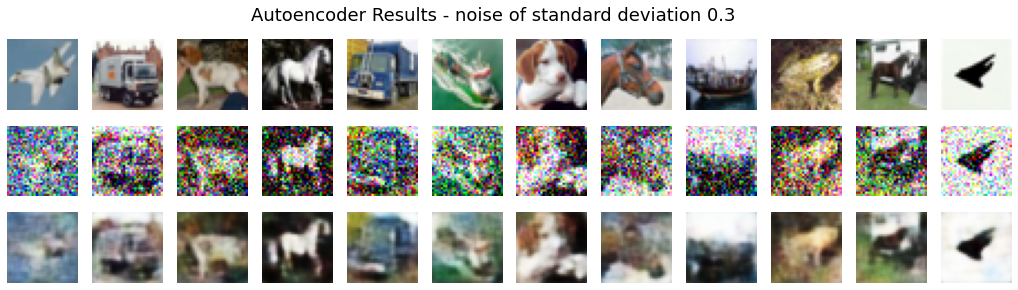

In [18]:
rows = 1 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*3)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*3,cols,((2*i)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_data_clean[2*i*cols + j+10]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*3,cols, ((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_data_noisy[2*i*cols + j+10]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*3,cols,((2*i+2)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_data_denoised[2*i*cols + j+10]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - noise of standard deviation "+str(sigma),fontsize=18)
plt.savefig("result_01.png")

plt.show()